In [ ]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler


In [ ]:
df = pd.read_csv("/mnt/data_sdd/event-aware/power_demand_final.csv")

## Goal
1. holiday_name 중 event-aware 부분을 기반으로 한 틸팅 기법을 적용한다,
---
2. model : 예측 적용 모델은 seq2seq-LSTM 을 사용하여 접근한다. [teacher forecing 기반으로 처리한다.]
    - 필요 항목 : Random Search, 시퀀스 데이터처리, Standard Scaler -> 데이터 길이 보전을 위한 블록 처리
    - 몽땅 예측이 맞나? 맞으면 70 :15 : 15로 분리 후 시퀀스 데이터 처리한다.
    - 이후 예측실시  

In [ ]:
df["일시"] = pd.to_datetime(df["일시"])
df1 = df.copy() # holiday_name : 이 부분은 먼저 제거한 상태로 접근 후 틸팅 분석을 통해서 접근한다.

df1.drop("holiday_name", axis=1, inplace=True)

In [ ]:
df1

,일시,hm,ta,power demand(MW),weekday,weekend,spring,summer,autoum,winter,is_holiday_dummies
0,2019-01-01 00:00:00,59.705026,-4.174162,65388.0,0,1,0,0,0,1,1
1,2019-01-01 01:00:00,60.096649,-4.349947,63045.0,0,1,0,0,0,1,1
2,2019-01-01 02:00:00,61.854850,-4.491993,61036.0,0,1,0,0,0,1,1
3,2019-01-01 03:00:00,63.020635,-4.648325,59834.0,0,1,0,0,0,1,1
4,2019-01-01 04:00:00,63.784303,-4.722354,59491.0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
51139,2024-10-31 19:00:00,75.547619,15.667637,67551.0,1,0,0,0,1,0,0
51140,2024-10-31 20:00:00,79.587125,14.787954,65341.0,1,0,0,0,1,0,0
51141,2024-10-31 21:00:00,82.265079,14.053263,63341.0,1,0,0,0,1,0,0
51142,2024-10-31 22:00:00,84.185538,13.475044,62031.0,1,0,0,0,1,0,0


In [ ]:
# 데이터 먼저 분리
total_len = len(df1)
train_end = int(total_len * 0.70)
val_end = int(total_len * 0.85)

train_df = df1.iloc[:train_end].copy()
val_df = df1.iloc[train_end:val_end].copy()
test_df = df1.iloc[val_end:].copy()

pd.concat([val_df, ], axis=1)

,일시,hm,ta,power demand(MW),weekday,weekend,spring,summer,autoum,winter,is_holiday_dummies
35800,2023-01-31 16:00:00,48.221825,8.329206,80236.0,1,0,0,0,0,1,0
35801,2023-01-31 17:00:00,52.147619,7.652579,80500.0,1,0,0,0,0,1,0
35802,2023-01-31 18:00:00,57.576587,6.462857,79806.0,1,0,0,0,0,1,0
35803,2023-01-31 19:00:00,63.071032,5.313333,78038.0,1,0,0,0,0,1,0
35804,2023-01-31 20:00:00,68.187500,4.375079,75417.0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
43467,2023-12-17 03:00:00,63.630612,-8.205306,59880.0,0,1,0,0,0,1,0
43468,2023-12-17 04:00:00,65.339796,-8.581156,59850.0,0,1,0,0,0,1,0
43469,2023-12-17 05:00:00,64.244558,-8.985986,60537.0,0,1,0,0,0,1,0
43470,2023-12-17 06:00:00,65.051020,-9.348163,61701.0,0,1,0,0,0,1,0


In [ ]:
# 위꺼 클릭하고 접근해 2번 클릭금지
val_df = pd.concat([val_df, test_df[test_df["일시"]<="2023-12-31 23:00:00"]],axis=0)
val_df = pd.concat([train_df[train_df["일시"]>="2023-01-01 00:00:00"], val_df],axis=0)

In [ ]:
train_df= train_df[train_df["일시"]<"2023-01-01 00:00:00"]
test_df = test_df[test_df["일시"]>"2023-12-31 23:00:00"]

In [ ]:
train_df.set_index("일시", inplace=True)
val_df.set_index("일시", inplace=True)
test_df.set_index("일시", inplace=True)

In [ ]:
train_df

,hm,ta,power demand(MW),weekday,weekend,spring,summer,autoum,winter,is_holiday_dummies
일시,,,,,,,,,,
2019-01-01 00:00:00,59.705026,-4.174162,65388.0,0,1,0,0,0,1,1
2019-01-01 01:00:00,60.096649,-4.349947,63045.0,0,1,0,0,0,1,1
2019-01-01 02:00:00,61.854850,-4.491993,61036.0,0,1,0,0,0,1,1
2019-01-01 03:00:00,63.020635,-4.648325,59834.0,0,1,0,0,0,1,1
2019-01-01 04:00:00,63.784303,-4.722354,59491.0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,66.365476,0.227351,67392.0,0,1,0,0,0,1,0
2022-12-31 20:00:00,70.338988,-0.551577,66648.0,0,1,0,0,0,1,0
2022-12-31 21:00:00,73.889286,-1.225030,65914.0,0,1,0,0,0,1,0


In [ ]:
class DailyStepDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, in_days, out_days, scaler_X, scaler_y):
        self.in_len  = in_days * 24
        self.out_len = out_days * 24
        self.stride  = 24  # 하루 단위 이동

        Xs = scaler_X.transform(df[feature_cols].values)
        ys = scaler_y.transform(df[[target_col]].values)

        self.X = torch.tensor(Xs, dtype=torch.float32)
        self.y = torch.tensor(ys, dtype=torch.float32)

        self.starts = range(0, len(self.X) - self.in_len - self.out_len + 1, self.stride)

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx):
        start = self.starts[idx]
        x_seq = self.X[start:start+self.in_len]
        y_seq = self.y[start+self.in_len:start+self.in_len+self.out_len]
        return x_seq, y_seq


In [ ]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = ["hm", "ta", "power demand(MW)",
                "spring", "summer", "autoum", "winter", "is_holiday_dummies"]
target_col   = "power demand(MW)"


scaler_X = MinMaxScaler().fit(train_df[feature_cols].values)
scaler_y = MinMaxScaler().fit(train_df[[target_col]].values)

train_ds = DailyStepDataset(
    train_df,
    feature_cols,
    target_col,
    in_days=7,        # 일 단위로만 구축
    out_days=1,       # 일 단위만 넣기
    scaler_X=scaler_X,
    scaler_y=scaler_y
)

val_ds = DailyStepDataset(
    val_df,
    feature_cols,
    target_col,
    in_days=7,        # 일 단위로만 구축
    out_days=1,       # 일 단위만 넣기
    scaler_X=scaler_X,
    scaler_y=scaler_y
)

test_ds = DailyStepDataset(
    test_df,
    feature_cols,
    target_col,
    in_days=7,        # 일 단위로만 구축
    out_days=1,       # 일 단위만 넣기
    scaler_X=scaler_X,
    scaler_y=scaler_y
)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from typing import Optional

# =========================================================
# 1) Dataset (일 단위 stride, 패딩+마스크, 빈 타깃 제외)
# =========================================================
class DailyStepDataset(Dataset):
    """
    - in_days: 입력 일 수 (정수)
    - out_days: 예측 일 수 (정수)
    - stride: 하루(24h) 고정 이동
    - feature_cols: 모델 입력에 쓸 모든 피처 (X)
    - target_col: 예측 대상 단일 컬럼명 (y)
    - scaler_X, scaler_y: 반드시 train으로만 fit해서 전달
    - pad_strategy: "zero" | "edge"
    - include_head_tail: True면 시계열 헤드/테일도 윈도우 생성(패딩으로 보정)
    - exclude_empty_targets: 타깃 마스크 합이 0인 샘플 제거
    """
    def __init__(self, df, feature_cols, target_col,
                 in_days, out_days, scaler_X, scaler_y,
                 pad_value=0.0, pad_strategy="zero",
                 include_head_tail=False,
                 exclude_empty_targets=True):
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.in_len = int(in_days) * 24
        self.out_len = int(out_days) * 24
        self.stride = 24

        Xs = scaler_X.transform(df[feature_cols].values)
        ys = scaler_y.transform(df[[target_col]].values).flatten()
        self.X = torch.tensor(Xs, dtype=torch.float32)
        self.y = torch.tensor(ys, dtype=torch.float32)

        self.T = len(self.X)
        self.pad_value = float(pad_value)
        self.pad_strategy = pad_strategy

        if include_head_tail:
            start_min = -(self.in_len - 1)
            start_max = self.T - 1
        else:
            start_min = 0
            start_max = self.T - self.in_len - self.out_len
        starts = list(range(start_min, start_max + 1, self.stride))

        # 필요 시 빈 타깃 샘플 제거
        if exclude_empty_targets:
            filtered = []
            for s in starts:
                out_start, out_end = s + self.in_len, s + self.in_len + self.out_len - 1
                real_out_s, real_out_e = max(out_start, 0), min(out_end, self.T - 1)
                y_real_len = max(0, real_out_e - real_out_s + 1)
                if y_real_len > 0:
                    filtered.append(s)
            self.starts = filtered
        else:
            self.starts = starts

    def __len__(self):
        return len(self.starts)

    def _left_pad(self, arr, need, feat=False):
        if need <= 0:
            return arr
        if self.pad_strategy == "edge" and len(arr) > 0:
            pad_val = arr[0:1] if not feat else arr[0:1, :]
            pad = pad_val.repeat(need, 1) if feat else pad_val.repeat(need)
        else:
            shape = (need, arr.shape[1]) if feat else (need,)
            pad = torch.full(shape, self.pad_value, dtype=arr.dtype)
        return torch.cat([pad, arr], dim=0)

    def _right_pad(self, arr, need):
        if need <= 0:
            return arr
        if self.pad_strategy == "edge" and len(arr) > 0:
            pad_val = arr[-1:]
            pad = pad_val.repeat(need)
        else:
            pad = torch.full((need,), self.pad_value, dtype=arr.dtype)
        return torch.cat([arr, pad], dim=0)

    def __getitem__(self, idx):
        s = self.starts[idx]
        in_start, in_end = s, s + self.in_len - 1
        out_start, out_end = s + self.in_len, s + self.in_len + self.out_len - 1

        # 입력 X 윈도우 (좌패딩 가능)
        real_in_s, real_in_e = max(in_start, 0), min(in_end, self.T - 1)
        x_part = self.X[real_in_s:real_in_e+1]
        left_need = real_in_s - in_start
        x_seq = self._left_pad(x_part, left_need, feat=True)

        # 타깃 y 윈도우 (우패딩/좌패딩 모두 가능)
        real_out_s, real_out_e = max(out_start, 0), min(out_end, self.T - 1)
        y_part = self.y[real_out_s:real_out_e+1] if real_out_s <= real_out_e else torch.empty(0)
        right_need = out_end - real_out_e
        y_seq = self._right_pad(y_part, right_need)
        if len(y_seq) < self.out_len:  # 헤드 구간은 좌패딩 필요할 수 있음
            y_seq = self._left_pad(y_seq, self.out_len - len(y_seq), feat=False)

        # 마스크: 실제 관측된 타깃 위치 = 1.0
        y_mask = torch.zeros(self.out_len, dtype=torch.float32)
        y_real_len = max(0, real_out_e - real_out_s + 1)
        if y_real_len > 0:
            left_pad_len = max(0, real_out_s - out_start)
            y_mask[left_pad_len:left_pad_len + y_real_len] = 1.0

        # 디코더 시작용 y0_prev (인코더 마지막 시점의 실제값 또는 pad_value)
        y0_idx = in_end
        if 0 <= y0_idx < self.T:
            y0_prev = self.y[y0_idx]
        else:
            y0_prev = torch.tensor(self.pad_value, dtype=self.y.dtype)

        return x_seq, y_seq.unsqueeze(-1), y_mask, y0_prev


# =========================================================
# 2) 모델 (Seq2Seq; 패딩-안전 Teacher Forcing)
# =========================================================
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hid_dim, n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
    def forward(self, x):
        return self.lstm(x)  # enc_outputs, (h,c)

class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, out_len, n_layers=1, dropout=0.0):
        super().__init__()
        assert input_dim == 1, "Decoder input must be scalar y (1)."
        self.out_len = out_len
        self.lstm = nn.LSTM(
            input_dim, hid_dim, n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hid_dim, 1)

    def forward(self, enc_outputs, states, y0, y_target=None, y_mask=None, teacher_forcing_ratio=0.5):
        h, c = states
        B = h.size(1)
        device = h.device
        inp = y0.unsqueeze(1).unsqueeze(2)  # [B,1,1]
        outputs = []
        for t in range(self.out_len):
            out, (h, c) = self.lstm(inp, (h, c))        # out: [B,1,hid]
            pred = self.fc(out.squeeze(1)).unsqueeze(1) # [B,1,1]
            outputs.append(pred)

            # 패딩 구간엔 TF 금지, 나머지는 확률적으로 TF
            if (y_target is not None) and (y_mask is not None):
                valid = (y_mask[:, t] > 0.5).float()              # [B]
                if teacher_forcing_ratio > 0.0 and valid.sum() > 0:
                    rand = torch.rand(B, device=device)
                    use_tf = (rand < teacher_forcing_ratio) * valid  # [B]
                    y_t = y_target[:, t].unsqueeze(1).unsqueeze(2)   # [B,1,1]
                    use_tf_bool = use_tf.bool().view(B,1,1)
                    inp = torch.where(use_tf_bool, y_t, pred)
                else:
                    inp = pred
            else:
                inp = pred
        return torch.cat(outputs, dim=1)  # [B,out_len,1]

class Seq2Seq(nn.Module):
    def __init__(self, enc_input_dim, dec_input_dim, hid_dim,
                 out_len, n_layers=1, dropout=0.0):
        super().__init__()
        self.encoder = Encoder(enc_input_dim, hid_dim, n_layers, dropout)
        self.decoder = Decoder(dec_input_dim, hid_dim, out_len, n_layers, dropout)
    def forward(self, x, y0, y_target=None, y_mask=None, teacher_forcing_ratio=0.5):
        enc_out, (h, c) = self.encoder(x)
        return self.decoder(enc_out, (h, c), y0,
                            y_target=y_target, y_mask=y_mask,
                            teacher_forcing_ratio=teacher_forcing_ratio)


# =========================================================
# 3) 학습/평가 루틴 (마스크 손실, ES, grad clip, 역스케일 지표)
# =========================================================

def masked_mse(preds, targets, mask, eps=1e-8):
    # preds/targets: [B, out_len] or [B, out_len, 1]; mask: [B, out_len]
    if preds.ndim == 3:
        preds = preds.squeeze(-1)
    if targets.ndim == 3:
        targets = targets.squeeze(-1)
    se = (preds - targets) ** 2
    se = se * mask
    denom = torch.clamp(mask.sum(), min=eps)
    return se.sum() / denom


def train_model(
    X_train, Y_train, M_train, y0_train,
    X_val,   Y_val,   M_val,   y0_val,
    X_test,  Y_test,  M_test,  y0_test,
    scaler_y,
    best_params: dict,
    device: torch.device,
    max_epochs: int = 150,
    patience: int = 10,
    grad_clip: Optional[float] = 1.0,
    ckpt_path: Optional[str] = None
):
    # Y shape 보정
    def sqz(y):
        return y.squeeze(-1) if (y.ndim == 3 and y.shape[-1] == 1) else y
    Y_train, Y_val, Y_test = sqz(Y_train), sqz(Y_val), sqz(Y_test)
    out_len = Y_train.shape[-1]

    # 모델
    model = Seq2Seq(
        enc_input_dim=X_train.shape[-1],
        dec_input_dim=1,
        hid_dim=int(best_params['units']),
        out_len=out_len,
        n_layers=int(best_params['lstm_layers']),
        dropout=float(best_params.get('lstm_dropout_rate', 0.0))
    ).to(device)

    criterion = masked_mse
    optimizer = optim.AdamW(model.parameters(), lr=float(best_params['learning_rate']))
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Tensor 변환
    def to_tensor_np(*arrs):
        return [torch.from_numpy(a).float() for a in arrs]
    Xtr, Ytr, Mtr, y0tr = to_tensor_np(X_train, Y_train, M_train, y0_train)
    Xva, Yva, Mva, y0va = to_tensor_np(X_val,   Y_val,   M_val,   y0_val)
    Xte, Yte, Mte, y0te = to_tensor_np(X_test,  Y_test,  M_test,  y0_test)

    tr_loader = DataLoader(TensorDataset(Xtr, Ytr, Mtr, y0tr), batch_size=int(best_params['batch_size']))
    va_loader = DataLoader(TensorDataset(Xva, Yva, Mva, y0va), batch_size=int(best_params['batch_size']))
    te_loader = DataLoader(TensorDataset(Xte, Yte, Mte, y0te), batch_size=int(best_params['batch_size']))

    # 학습 루프
    best_val = float('inf')
    bad = 0
    train_losses, val_losses = [], []

    if ckpt_path is None:
        stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        ckpt_path = f'best_model_{stamp}.pth'

    tfr = float(best_params.get('teacher_forcing_ratio', 0.5))

    for epoch in range(1, max_epochs + 1):
        # ---- Train ----
        model.train()
        total_tr = 0.0
        for xb, yb, mb, y0b in tr_loader:
            xb, yb, mb, y0b = xb.to(device), yb.to(device), mb.to(device), y0b.to(device)
            optimizer.zero_grad(set_to_none=True)
            preds = model(xb, y0b, y_target=yb, y_mask=mb, teacher_forcing_ratio=tfr)
            loss = criterion(preds, yb, mb)
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            total_tr += loss.item()
        tr_loss = total_tr / max(1, len(tr_loader))
        train_losses.append(tr_loss)

        # ---- Validate ----
        model.eval()
        total_va = 0.0
        with torch.no_grad():
            for xb, yb, mb, y0b in va_loader:
                xb, yb, mb, y0b = xb.to(device), yb.to(device), mb.to(device), y0b.to(device)
                preds = model(xb, y0b, y_target=None, y_mask=None, teacher_forcing_ratio=0.0)
                total_va += criterion(preds, yb, mb).item()
        val_loss = total_va / max(1, len(va_loader))
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        # ---- Early stopping ----
        if val_loss < best_val - 1e-8:
            best_val = val_loss
            bad = 0
            torch.save(model.state_dict(), ckpt_path)
        else:
            bad += 1

        if epoch == 1 or epoch % 10 == 0:
            lr_now = optimizer.param_groups[0]['lr']
            print(f"[{epoch}/{max_epochs}] Train={tr_loss:.4f}  Val={val_loss:.4f}  LR={lr_now:.2e}  (bad={bad}/{patience})")

        if epoch > 20 and bad >= patience:
            print(f"Early stopping at epoch {epoch} (best_val={best_val:.6f})")
            break

    # ---- 공통 추론 유틸: loader 단위 예측/지표 산출 ----
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    def _infer_and_metrics(loader, Y_true_np, M_np):
        preds_list = []
        masks_list = []
        with torch.no_grad():
            for xb, yb, mb, y0b in loader:
                xb, yb, mb, y0b = xb.to(device), yb.to(device), mb.to(device), y0b.to(device)
                preds = model(xb, y0b, y_target=None, y_mask=None, teacher_forcing_ratio=0.0)
                preds_list.append(preds.cpu())
                masks_list.append(mb.cpu())
        preds_all = torch.cat(preds_list, dim=0).squeeze(-1).numpy()
        masks_all = torch.cat(masks_list, dim=0).numpy().astype(bool)

        y_pred_inv = scaler_y.inverse_transform(preds_all.reshape(-1, 1)).reshape(preds_all.shape)
        y_true_inv = scaler_y.inverse_transform(Y_true_np.reshape(-1, 1)).reshape(Y_true_np.shape)

        diff = (y_pred_inv - y_true_inv)
        mask = masks_all
        denom = mask.sum()
        if denom == 0:
            metrics = {"mae": float('nan'), "rmse": float('nan'), "mape": float('nan')}
        else:
            mae  = float(np.abs(diff)[mask].mean())
            rmse = float(np.sqrt((diff[mask] ** 2).mean()))
            mape = float((np.abs(diff[mask]) / np.clip(np.abs(y_true_inv[mask]), 1e-8, None)).mean() * 100.0)
            metrics = {"mae": mae, "rmse": rmse, "mape": mape}
        return y_pred_inv, masks_all, metrics


    # ---- Test ----
    test_preds_inv, test_masks, test_metrics = _infer_and_metrics(te_loader, Y_test, M_test)
    print(f"[TEST]  MAE={test_metrics['mae']:.3f}  RMSE={test_metrics['rmse']:.3f}  MAPE={test_metrics['mape']:.2f}%")

    # ---- Train/Val fitted 결과 ----
    train_preds_inv, train_masks, train_metrics = _infer_and_metrics(tr_loader, Y_train, M_train)
    val_preds_inv,   val_masks,   val_metrics   = _infer_and_metrics(va_loader, Y_val,   M_val)

    print(f"[TRAIN] MAE={train_metrics['mae']:.3f}  RMSE={train_metrics['rmse']:.3f}  MAPE={train_metrics['mape']:.2f}%")
    print(f"[VAL]   MAE={val_metrics['mae']:.3f}  RMSE={val_metrics['rmse']:.3f}  MAPE={val_metrics['mape']:.2f}%")

    # 리턴 값 확장: (모델/학습곡선/셋별 지표와 예측/마스크/체크포인트 경로)
    return (model, train_losses, val_losses,
            test_metrics, test_preds_inv, test_masks, ckpt_path,
            train_preds_inv, train_masks, train_metrics,
            val_preds_inv,   val_masks,   val_metrics)


# =========================================================
# 4) 유틸: Dataset -> numpy 변환
# =========================================================
def ds_to_numpy(ds: DailyStepDataset):
    X_list, Y_list, M_list, y0_list = [], [], [], []
    for x, y, m, y0 in ds:
        X_list.append(x.numpy())
        Y_list.append(y.numpy())
        M_list.append(m.numpy())
        y0_list.append(float(y0.item()))
    X = np.stack(X_list)
    Y = np.stack(Y_list)
    M = np.stack(M_list)
    y0 = np.array(y0_list)
    return X, Y, M, y0


# =========================================================
# 5) __main__ 예시 (이 코드 적용)
# =========================================================
if __name__ == "__main__":
    # ※ 사용 전제: 아래의 train_df, val_df, test_df가 시간순으로 미리 분할되어 있어야 합니다.
    # 예) train_df, val_df, test_df = ... (DatetimeIndex 권장)
    try:
        train_df
        val_df
        test_df
    except NameError:
        raise RuntimeError(
            "train_df/val_df/test_df 변수가 필요합니다. 이들을 미리 생성해 주세요 (시간 기준 분할)."
        )

    # --- 피처/타깃 정의 ---
    feature_cols = [
        "hm", "ta", "power demand(MW)",
        "weekday", "weekend",
        "spring", "summer", "autoum", "winter",
        "is_holiday_dummies"
    ]
    target_col = "power demand(MW)"

    # 필요 시 라그/이동평균 추가 예시
    # for df in (train_df, val_df, test_df):
    #     df["demand_lag24"] = df[target_col].shift(24)
    #     df["demand_lag48"] = df[target_col].shift(48)
    #     df["demand_ma7d"]  = df[target_col].shift(24).rolling(7).mean()
    # feature_cols += ["demand_lag24", "demand_lag48", "demand_ma7d"]

    # --- 스케일러 (train으로만 fit) ---
    scaler_X = MinMaxScaler().fit(train_df[feature_cols].values)
    scaler_y = MinMaxScaler().fit(train_df[[target_col]].values)

    # --- Dataset 생성 ---
    in_days, out_days = 14, 1
    pad_value = 0.0  # MinMax 기준 0~1 범위에서 안전

    train_ds = DailyStepDataset(
        train_df, feature_cols, target_col,
        in_days, out_days, scaler_X, scaler_y,
        pad_value=pad_value, pad_strategy="zero",
        include_head_tail=False,  # 일반적으로 False 권장
        exclude_empty_targets=True
    )
    val_ds = DailyStepDataset(
        val_df, feature_cols, target_col,
        in_days, out_days, scaler_X, scaler_y,
        pad_value=pad_value, pad_strategy="zero",
        include_head_tail=False,
        exclude_empty_targets=True
    )
    test_ds = DailyStepDataset(
        test_df, feature_cols, target_col,
        in_days, out_days, scaler_X, scaler_y,
        pad_value=pad_value, pad_strategy="zero",
        include_head_tail=False,
        exclude_empty_targets=True
    )

    # --- numpy로 변환 ---
    X_train, Y_train, M_train, y0_train = ds_to_numpy(train_ds)
    X_val,   Y_val,   M_val,   y0_val   = ds_to_numpy(val_ds)
    X_test,  Y_test,  M_test,  y0_test  = ds_to_numpy(test_ds)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # --- 하이퍼파라미터 ---
    best_params = {
        "lstm_layers": 2,
        "units": 128,
        "learning_rate": 3e-4,
        "teacher_forcing_ratio": 0.5,  # train에서만 사용, val/test는 0.0
        "lstm_dropout_rate": 0.1,
        "batch_size": 64,
    }

    (model, tr_losses, va_losses,
     test_metrics, test_preds_inv, test_masks, ckpt_path,
     train_preds_inv, train_masks, train_metrics,
     val_preds_inv,   val_masks,   val_metrics) = train_model(
        X_train, Y_train, M_train, y0_train,
        X_val,   Y_val,   M_val,   y0_val,
        X_test,  Y_test,  M_test,  y0_test,
        scaler_y,
        best_params,
        device=device,
        max_epochs=150,
        patience=10,
        grad_clip=1.0,
    )

    print("\nBest checkpoint saved to:", ckpt_path)
    print("Test metrics:", test_metrics)
    print("Train metrics:", train_metrics)
    print("Val metrics:", val_metrics)


[1/150] Train=0.0966  Val=0.0255  LR=3.00e-04  (bad=0/10)
[10/150] Train=0.0181  Val=0.0186  LR=3.00e-04  (bad=0/10)
[20/150] Train=0.0129  Val=0.0168  LR=3.00e-04  (bad=0/10)
[30/150] Train=0.0104  Val=0.0137  LR=1.50e-04  (bad=0/10)
[40/150] Train=0.0070  Val=0.0142  LR=1.50e-04  (bad=5/10)
[50/150] Train=0.0054  Val=0.0107  LR=7.50e-05  (bad=0/10)
[60/150] Train=0.0045  Val=0.0087  LR=7.50e-05  (bad=0/10)
[70/150] Train=0.0040  Val=0.0073  LR=7.50e-05  (bad=0/10)
[80/150] Train=0.0037  Val=0.0067  LR=7.50e-05  (bad=0/10)
[90/150] Train=0.0036  Val=0.0065  LR=7.50e-05  (bad=1/10)
[100/150] Train=0.0034  Val=0.0063  LR=7.50e-05  (bad=0/10)
[110/150] Train=0.0033  Val=0.0062  LR=7.50e-05  (bad=0/10)
[120/150] Train=0.0032  Val=0.0060  LR=7.50e-05  (bad=0/10)
[130/150] Train=0.0029  Val=0.0059  LR=7.50e-05  (bad=1/10)
[140/150] Train=0.0026  Val=0.0055  LR=7.50e-05  (bad=0/10)
[150/150] Train=0.0024  Val=0.0053  LR=7.50e-05  (bad=0/10)
[TEST]  MAE=3128.726  RMSE=4346.119  MAPE=4.97%
[TR

In [ ]:
train_df["power demand(MW)"].values

일시
2019-01-01 00:00:00    65388.0
2019-01-01 01:00:00    63045.0
2019-01-01 02:00:00    61036.0
2019-01-01 03:00:00    59834.0
2019-01-01 04:00:00    59491.0
                        ...   
2022-12-31 19:00:00    67392.0
2022-12-31 20:00:00    66648.0
2022-12-31 21:00:00    65914.0
2022-12-31 22:00:00    65739.0
2022-12-31 23:00:00    67067.0
Name: power demand(MW), Length: 35064, dtype: float64

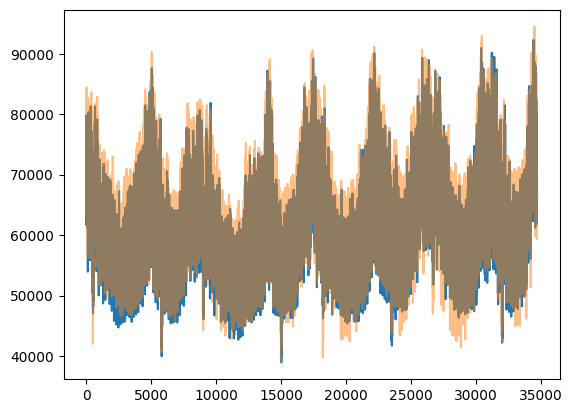

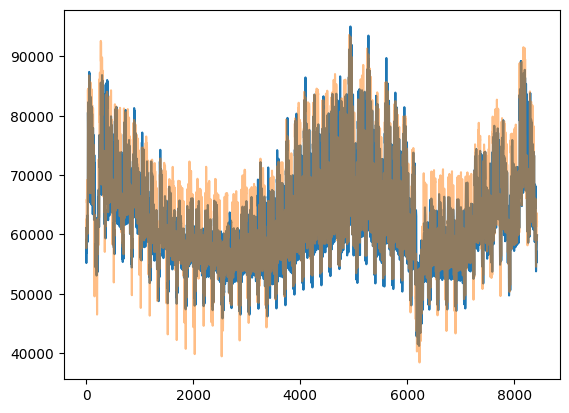

In [ ]:
plt.plot(train_preds_inv.flatten())
plt.plot(train_df["power demand(MW)"][-len(train_preds_inv.flatten()):].values, alpha=0.5)
plt.show()

plt.plot(val_preds_inv.flatten())
plt.plot(val_df["power demand(MW)"][-len(val_preds_inv.flatten()):].values, alpha=0.5)

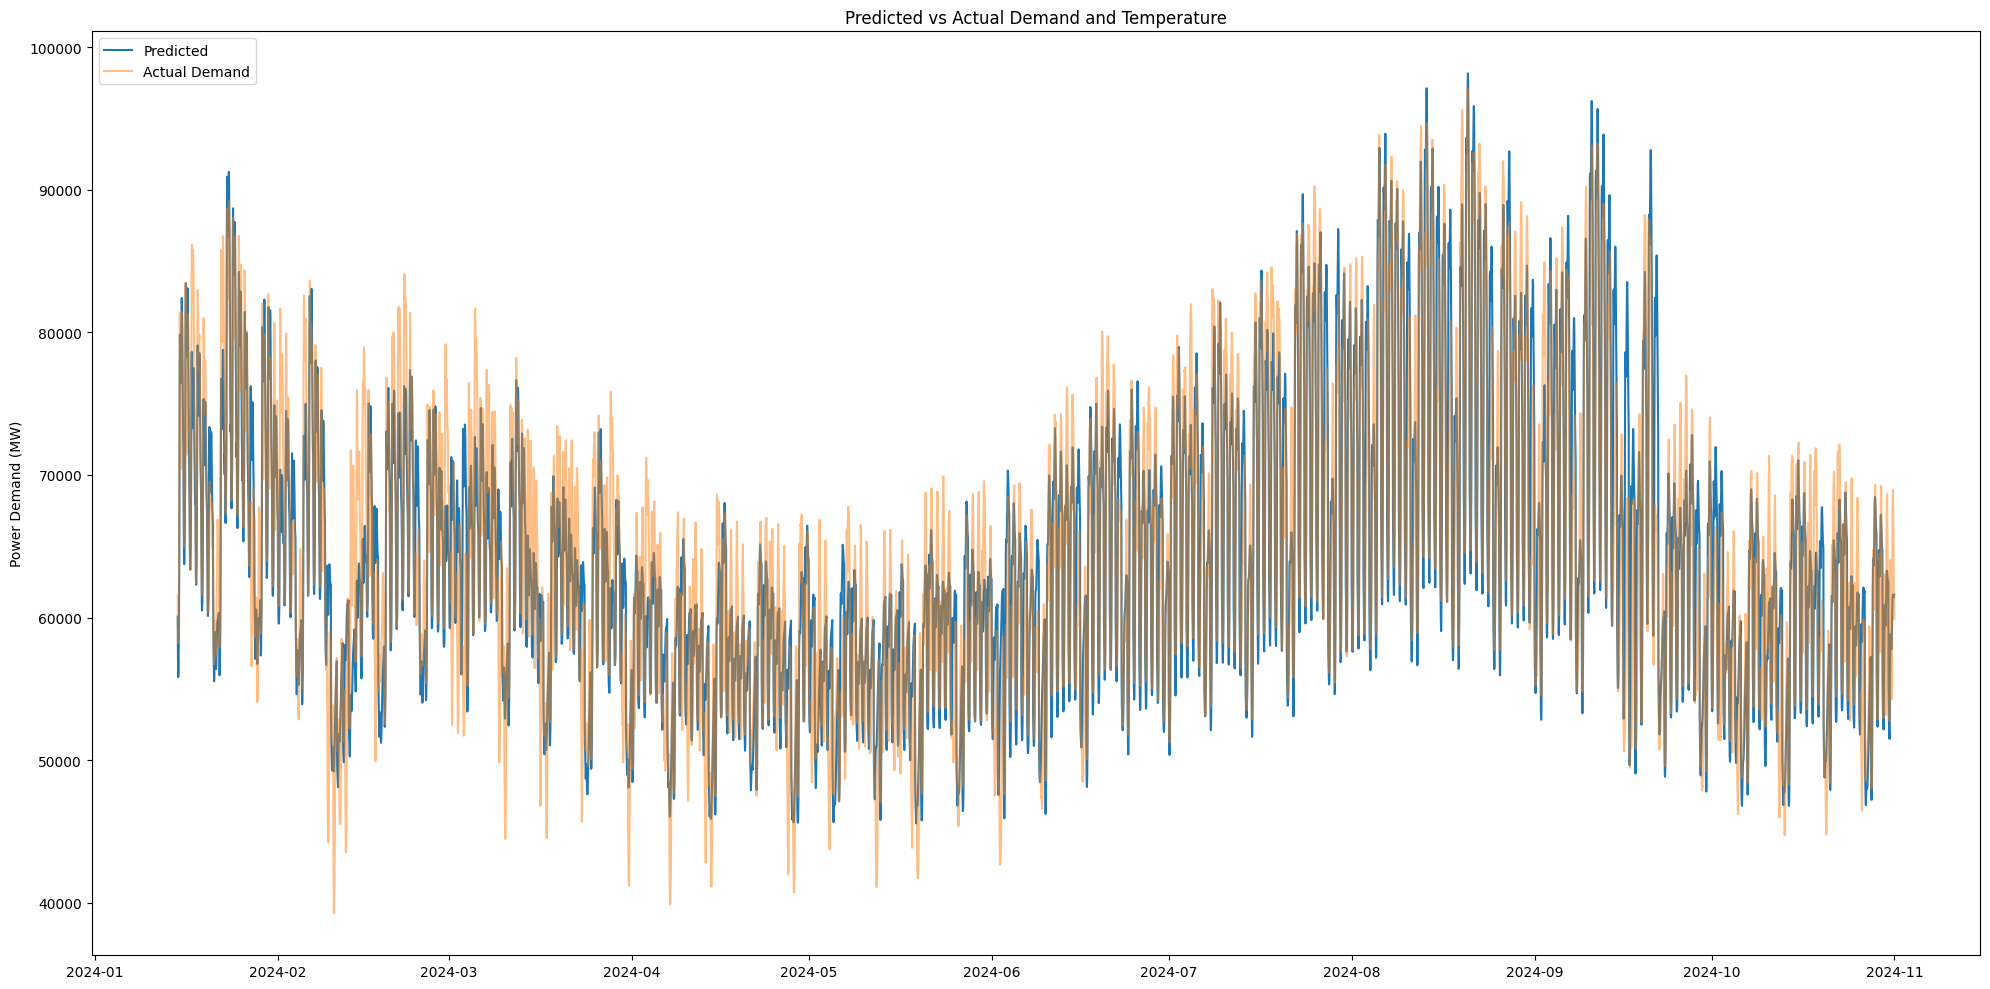

In [ ]:
import matplotlib.pyplot as plt

# Figure, 1개의 Axes 생성
fig, ax1 = plt.subplots(figsize=(20, 10))

# x축 범위 설정
x_idx = test_df.index[-len(test_preds_inv.flatten()):]

# 첫 번째 y축 (전력 수요, 예측/실제)
ax1.plot(x_idx, test_preds_inv.flatten(), label="Predicted", color="tab:blue")
ax1.plot(x_idx, test_df["power demand(MW)"].values[-len(x_idx):],
         alpha=0.5, label="Actual Demand", color="tab:orange")
ax1.set_ylabel("Power Demand (MW)")
ax1.legend(loc="upper left")

plt.title("Predicted vs Actual Demand and Temperature")
plt.tight_layout()
plt.show()


### fitting 된 부분에 event-aware 정보 사용

In [ ]:
df

,일시,hm,ta,power demand(MW),holiday_name,weekday,weekend,spring,summer,autoum,winter,is_holiday_dummies
0,2019-01-01 00:00:00,59.705026,-4.174162,65388.0,New Year's Day,0,1,0,0,0,1,1
1,2019-01-01 01:00:00,60.096649,-4.349947,63045.0,New Year's Day,0,1,0,0,0,1,1
2,2019-01-01 02:00:00,61.854850,-4.491993,61036.0,New Year's Day,0,1,0,0,0,1,1
3,2019-01-01 03:00:00,63.020635,-4.648325,59834.0,New Year's Day,0,1,0,0,0,1,1
4,2019-01-01 04:00:00,63.784303,-4.722354,59491.0,New Year's Day,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
51139,2024-10-31 19:00:00,75.547619,15.667637,67551.0,NaN,1,0,0,0,1,0,0
51140,2024-10-31 20:00:00,79.587125,14.787954,65341.0,NaN,1,0,0,0,1,0,0
51141,2024-10-31 21:00:00,82.265079,14.053263,63341.0,NaN,1,0,0,0,1,0,0
51142,2024-10-31 22:00:00,84.185538,13.475044,62031.0,NaN,1,0,0,0,1,0,0


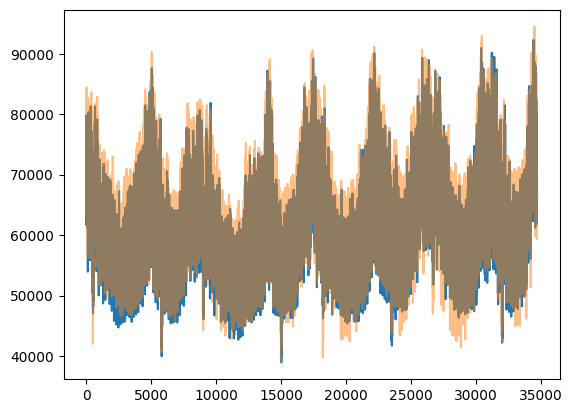

In [ ]:
plt.plot(train_preds_inv.flatten())
plt.plot(train_df["power demand(MW)"][-len(train_preds_inv.flatten()):].values, alpha=0.5)
plt.show()

# 
train_tilting = pd.DataFrame(train_preds_inv.flatten(), columns=["demand_fitting"])
train_tilting["holiday_type"] = df["holiday_name"][:len(train_preds_inv.flatten())]
train_tilting["real_demand"] = train_df["power demand(MW)"][-len(train_preds_inv.flatten()):].values

In [ ]:
# =========================================================
# Hierarchical Quadratic Tilting (HQT) — Full Code (for your columns)
# ---------------------------------------------------------
# 수식:
#   z_t = (y - yhat)/sigma
#   δ_i(τ) = β_{i0} + β_{i1} τ + β_{i2} τ^2
#   β_i ~ N( μ_{h(i)}, Σ_{h(i)} )
#   y_tilt = yhat + sigma * E[δ_i(τ)]
# 컬럼명:
#   yhat -> "demand_fitting"
#   y    -> "real_demand"
#   holiday_type -> "holiday_type" (NaN = 비이벤트)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc as pm
import pytensor.tensor as pt
import arviz as az


# -----------------------------
# 1) tau / event_id 자동 생성
# -----------------------------
def ensure_tau_event_id(df: pd.DataFrame,
                        holiday_col="holiday_type",
                        event_col="event_id",
                        tau_col="tau",
                        center_strategy="middle"):
    """
    - holiday_type이 NaN이 아닌 연속 구간을 개별 이벤트(event_id)로 라벨링
    - tau는 각 이벤트 구간에서 중심일을 0으로, 앞뒤를 ±1, ±2,...로 부여
    - center_strategy: "middle"(기본) | "first" | "last"
    """
    out = df.copy()
    if event_col not in out.columns or out[event_col].isna().all():
        is_event = out[holiday_col].notna()
        group_switch = (is_event != is_event.shift(1)).cumsum()
        out[event_col] = np.where(is_event, group_switch, np.nan)

    if tau_col not in out.columns or out[tau_col].isna().all():
        out[tau_col] = np.nan
        for eid, g in out[out[holiday_col].notna()].groupby(event_col, sort=False):
            n = len(g)
            if n == 0:
                continue
            if center_strategy == "first":
                tau = np.arange(n) - 0
            elif center_strategy == "last":
                tau = np.arange(n) - (n - 1)
            else:  # "middle"
                tau = np.arange(n) - (n // 2)
            out.loc[g.index, tau_col] = tau.astype(int)
    return out


# -----------------------------
# 2) 메인: HQT PyMC 적합
# -----------------------------
def fit_hqt_pymc(tilt_df: pd.DataFrame,
                 holiday_col="holiday_type",
                 y_col="real_demand",
                 yhat_col="demand_fitting",
                 tau_col="tau",
                 event_col="event_id",
                 draws=2000, tune=1000, target_accept=0.9, random_seed=42,
                 sigma_override: float | None = None):
    """
    계층 베이지안 2차 틸팅:
      z = (y - yhat) / sigma  (sigma: 비이벤트 표준편차; 없으면 sigma_override 사용)
      z ~ Normal(β0_i + β1_i τ + β2_i τ^2, σ_r)
      β_i ~ N( μ_{h(i)}, Σ_{h(i)} )   # holiday type별 partial pooling
    Returns:
      {"df": df_out, "sigma": sigma, "idata": idata}
    """
    df = tilt_df.copy()

    # 비이벤트 표기 정규화(빈문자/None/0 등을 NaN으로)
    df[holiday_col] = df[holiday_col].replace(["", "None", 0, "0", "non", "normal"], np.nan)

    # tau / event_id 자동 생성 (없을 때)
    if (tau_col not in df.columns) or (event_col not in df.columns):
        df = ensure_tau_event_id(df, holiday_col=holiday_col, event_col=event_col, tau_col=tau_col)

    # 표준화 잔차 z = (y - yhat) / sigma
    resid = (df[y_col].astype(float) - df[yhat_col].astype(float))

    if sigma_override is None:
        non_event_mask = df[holiday_col].isna()
        sigma = resid[non_event_mask].std(ddof=1)
        if not np.isfinite(sigma) or sigma <= 0:
            # 백업: 전체 잔차의 MAD 기반 견고 추정
            mad = np.median(np.abs(resid - np.median(resid)))
            sigma = 1.4826 * mad
            if not np.isfinite(sigma) or sigma <= 0:
                raise ValueError("σ 계산 실패: 비이벤트가 없거나 분산=0. sigma_override로 값을 넘겨주세요.")
    else:
        sigma = float(sigma_override)

    df["z"] = resid / sigma

    # 이벤트 구간만 모델링
    ev = df[~df[holiday_col].isna()].copy()
    if ev.empty:
        raise ValueError("이벤트 구간이 없습니다(holiday_type 전부 NaN).")

    # 인덱스 인코딩 (이벤트 i, 타입 h(i))
    ev["event_idx"], event_uniques = pd.factorize(ev[event_col], sort=False)
    ev["type_idx"],  type_uniques  = pd.factorize(ev[holiday_col], sort=True)

    I = int(ev["event_idx"].max()) + 1   # 이벤트 개수
    H = int(ev["type_idx"].max()) + 1    # holiday type 개수

    # 각 이벤트의 타입 인덱스 (길이 I)
    event_type_idx = ev.groupby("event_idx", sort=False)["type_idx"].first().reindex(range(I)).astype(int).values

    # 관측 벡터
    event_idx = ev["event_idx"].astype(int).values
    tau = ev[tau_col].astype(float).values
    tau2 = tau ** 2
    z_obs = ev["z"].astype(float).values

    with pm.Model() as model:
        # holiday type별 평균벡터 μ_h (β0, β1, β2)
        mu_h = pm.Normal("mu_h", mu=0.0, sigma=10.0, shape=(H, 3))

        # holiday type별 공분산 (LKJCholeskyCov)
        # 5) holiday type별 공분산 (루프 생성 → stack)
        sd_dist = pm.HalfNormal.dist(1.0)
        chol_list = []
        for h in range(H):
            chol_h, corr_h, sigmas_h = pm.LKJCholeskyCov(
                f"chol_h_{h}", n=3, eta=2.0, sd_dist=sd_dist, compute_corr=True
            )
            chol_list.append(chol_h)
        chol_stack = pt.stack(chol_list, axis=0)  # (H,3,3)

        # 6) 이벤트별 β_i ~ MVN( μ_{h(i)}, Σ_{h(i)} )
        beta_event = pm.MvNormal(
            "beta_event",
            mu=mu_h[event_type_idx],        # (I,3)
            chol=chol_stack[event_type_idx],# (I,3,3)
            shape=(I, 3)
        )

        # 관측별 회귀평균
        b0 = beta_event[event_idx, 0]
        b1 = beta_event[event_idx, 1]
        b2 = beta_event[event_idx, 2]

        sigma_r = pm.HalfNormal("sigma_r", sigma=1.0)
        mu_z = b0 + b1 * tau + b2 * tau2

        pm.Normal("z_like", mu=mu_z, sigma=sigma_r, observed=z_obs)

        idata = pm.sample(
            draws=draws, tune=tune, target_accept=target_accept,
            chains=4, random_seed=random_seed, progressbar=True
        )

    # Posterior에서 δ(τ) 기대값 / 95%구간 → y_tilt 산출
    post_be = idata.posterior["beta_event"]      # (chain, draw, I, 3) xarray
    be = post_be.stack(sample=("chain","draw"))  # (sample, I, 3)
    be_np = np.asarray(be)                       # NumPy array

    be_mean = be_np.mean(axis=0)                 # (I,3)
    z_hat_mean = be_mean[event_idx, 0] + be_mean[event_idx, 1]*tau + be_mean[event_idx, 2]*(tau2)

    # 95% CI (2.5~97.5%)
    z_hat_samps = (
        be_np[:, event_idx, 0] +
        be_np[:, event_idx, 1] * tau[None, :] +
        be_np[:, event_idx, 2] * tau2[None, :]
    )  # (sample, N)
    z_lo = np.percentile(z_hat_samps, 2.5, axis=0)
    z_hi = np.percentile(z_hat_samps, 97.5, axis=0)

    ev["z_hat_mean"] = z_hat_mean
    ev["z_hat_lo"]   = z_lo
    ev["z_hat_hi"]   = z_hi

    # MW 단위 보정 및 최종 예측
    ev["e_tilt_mean"] = sigma * ev["z_hat_mean"]
    ev["e_tilt_lo"]   = sigma * ev["z_hat_lo"]
    ev["e_tilt_hi"]   = sigma * ev["z_hat_hi"]

    ev["y_tilt_mean"] = ev[yhat_col].values + ev["e_tilt_mean"].values
    ev["y_tilt_lo"]   = ev[yhat_col].values + ev["e_tilt_lo"].values
    ev["y_tilt_hi"]   = ev[yhat_col].values + ev["e_tilt_hi"].values

    # 전체 DF로 병합
    df_out = df.copy()
    for c in ["z","z_hat_mean","z_hat_lo","z_hat_hi",
              "e_tilt_mean","e_tilt_lo","e_tilt_hi",
              "y_tilt_mean","y_tilt_lo","y_tilt_hi"]:
        if c not in df_out.columns:
            df_out[c] = np.nan
    df_out.loc[ev.index, ["z","z_hat_mean","z_hat_lo","z_hat_hi",
                          "e_tilt_mean","e_tilt_lo","e_tilt_hi",
                          "y_tilt_mean","y_tilt_lo","y_tilt_hi"]] = ev[[
                              "z","z_hat_mean","z_hat_lo","z_hat_hi",
                              "e_tilt_mean","e_tilt_lo","e_tilt_hi",
                              "y_tilt_mean","y_tilt_lo","y_tilt_hi"
                          ]].values

    return {"df": df_out, "sigma": sigma, "idata": idata}


# -----------------------------
# 3) 시각화/평가 유틸
# -----------------------------
def plot_tilt_result(df_out: pd.DataFrame,
                     holiday_keyword="Chuseok",
                     y_col="real_demand",
                     yhat_col="demand_fitting",
                     ytilt_col="y_tilt_mean",
                     lo_col="y_tilt_lo",
                     hi_col="y_tilt_hi",
                     holiday_col="holiday_type",
                     start_idx=None, end_idx=None,
                     title=None, figsize=(10,4)):
    m = df_out[holiday_col].astype(str).str.contains(holiday_keyword, case=False, na=False)
    sub = df_out.loc[m, [y_col, yhat_col, ytilt_col, lo_col, hi_col]].copy()
    if start_idx is not None or end_idx is not None:
        sub = sub.iloc[slice(start_idx, end_idx)]
    if title is None:
        title = f"{holiday_keyword} — Baseline vs Tilt (HQT)"

    plt.figure(figsize=figsize)
    plt.plot(sub[y_col].values, label="Actual", alpha=0.65)
    plt.plot(sub[yhat_col].values, label="Baseline", linestyle="--")
    plt.plot(sub[ytilt_col].values, label="Tilted (mean)", linewidth=2)
    if lo_col in sub.columns and hi_col in sub.columns:
        x = np.arange(len(sub))
        plt.fill_between(x, sub[lo_col].values, sub[hi_col].values, alpha=0.2, label="Tilted 95% CI")
    plt.title(title); plt.xlabel("Index in selection"); plt.ylabel("Load (MW)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


def compare_metrics(df_out: pd.DataFrame,
                    holiday_keyword="Chuseok",
                    y_col="real_demand",
                    yhat_col="demand_fitting",
                    ytilt_col="y_tilt_mean",
                    holiday_col="holiday_type"):
    m = df_out[holiday_col].astype(str).str.contains(holiday_keyword, case=False, na=False)
    sub = df_out.loc[m, [y_col, yhat_col, ytilt_col]].dropna()
    if sub.empty:
        print(f"[WARN] '{holiday_keyword}' 구간이 비어 있습니다.")
        return
    y = sub[y_col].values
    yhat = sub[yhat_col].values
    ytilt = sub[ytilt_col].values

    mae_b = np.mean(np.abs(y - yhat))
    rmse_b = np.sqrt(np.mean((y - yhat)**2))
    mae_t = np.mean(np.abs(y - ytilt))
    rmse_t = np.sqrt(np.mean((y - ytilt)**2))

    print(f"[{holiday_keyword}] MAE  baseline={mae_b:.3f}  tilted={mae_t:.3f}  Δ={mae_t - mae_b:+.3f}")
    print(f"[{holiday_keyword}] RMSE baseline={rmse_b:.3f}  tilted={rmse_t:.3f}  Δ={rmse_t - rmse_b:+.3f}")


df_ready = train_tilting.copy()  # 네 데이터프레임
df_ready["holiday_type"] = df_ready["holiday_type"].replace(["", "None", 0], np.nan)

# (선택) 비이벤트가 거의 없다면, 훈련 전체 잔차 표준편차로 sigma_override 지정 가능
# sigma_global = (df_ready["real_demand"] - df_ready["demand_fitting"]).std(ddof=1)

res = fit_hqt_pymc(
    df_ready,
    holiday_col="holiday_type",
    y_col="real_demand",
    yhat_col="demand_fitting",
    tau_col="tau",
    event_col="event_id",
    draws=2000, tune=1000, target_accept=0.9,
    # sigma_override=sigma_global,  # 필요시 주석 해제
)
df_out = res["df"]; sigma = res["sigma"]; idata = res["idata"]

# 플롯/지표 (예: 추석 3~6일(시간단위면 24*3~24*6))
plot_tilt_result(df_out, holiday_keyword="Chuseok", start_idx=24*3, end_idx=24*6)
compare_metrics(df_out, holiday_keyword="Chuseok")
compare_metrics(df_out, holiday_keyword="Seollal")

Initializing NUTS using jitter+adapt_diag...
/mnt/data_sdd/event-aware/.venv/lib/python3.10/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_h, chol_h_0, chol_h_1, chol_h_2, chol_h_3, chol_h_4, chol_h_5, chol_h_6, chol_h_7, chol_h_8, chol_h_9, chol_h_10, chol_h_11, chol_h_12, chol_h_13, chol_h_14, chol_h_15, chol_h_16, chol_h_17

/mnt/data_sdd/event-aware/.venv/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 678 draw iterations (3_000 + 2_034 draws total) took 4791 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


IndexError: index 3 is out of bounds for axis 0 with size 3